In [1]:
import torch
import einops
from PIL import Image
from datasets import load_dataset
from pytorch_wavelets import DWTForward, DWTInverse 
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor

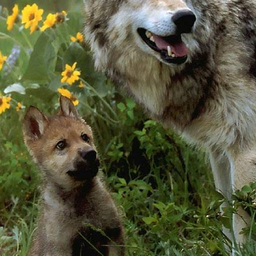

In [2]:
device="cuda:0"
train_dataset = load_dataset("danjacobellis/imagenet_hq", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=1,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [3]:
dwt = DWTForward(J=1, mode='zero', wave='haar').to(device)
idwt = DWTInverse(mode='zero', wave='haar').to(device)

In [4]:
with torch.no_grad():
    x = valid_batch.clone()
    L, H = dwt(x)
    X = torch.cat([L.unsqueeze(1),H[0]],dim=1)

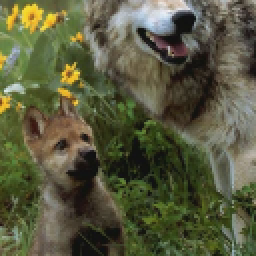

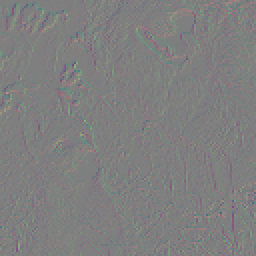

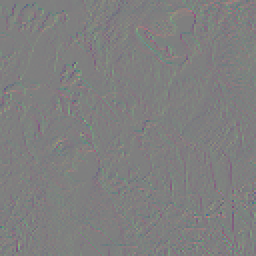

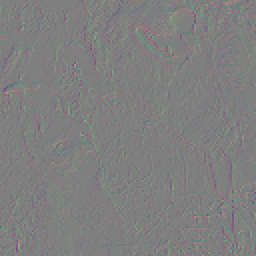

In [5]:
for i in range(X.shape[1]):
    img = X[:,i,:,:,:]
    img = img/2
    img = img.tanh()
    display(ToPILImage()(img[0]+0.5).resize((256,256),resample=Image.Resampling.NEAREST))

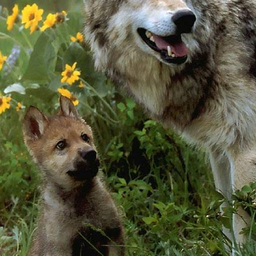

In [6]:
with torch.no_grad():
    L, H = torch.split(X, [1, 3], dim=1)
    L = L.squeeze(1)
    H = [H]
    Y = idwt((L, H))

for img in valid_batch:
    display(ToPILImage()(img+0.5))